# Exploring underwriting data

Import libraries

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math

Read pickle to dataframe

In [34]:
df = pd.read_pickle('Z:\PMO\Stephen Bowie\Projects\Underwriting\Model\Cleaned Model Data')

**Dataframe fields:** 

Customer attributes:
- 'call'
- 'auto_hist'
- 'emp_length'
- 'poi'
- 'annual_inc'
- 'address_length'
- 'credit_score'

Vehicle attributes:
- 'acv'
- 'pack'
- 'purch_type'

Deal structure:
- 'trade_roll'
- 'brand'
- 'date_sold'
- 'amt_fin'
- 'mo_pmt'
- 'ltv'
- 'gross_profit'
- 'down'
- 'def_down'
- 'vdc'

Response:
- 'repo_in_12'

In [76]:
df[['purch_type','repo_in_12']].groupby('purch_type').count()

,repo_in_12
purch_type,
auction,2954
simulcast,914
repo,2333
trade,938


In [74]:
df.isnull().sum() / df['auto_hist'].count()

auto_hist         0.000000
emp_length        0.000000
poi               0.000000
annual_inc        0.000000
address_length    0.000000
acv               0.000000
trade_roll        0.000000
pack              0.000000
brand             0.000000
date_sold         0.000000
amt_fin           0.000000
mo_pmt            0.000000
call              0.005844
ltv               0.000000
gross_profit      0.000000
down              0.000000
def_down          0.000000
vdc               0.000000
purch_type        0.006679
credit_score      0.398497
repo_in_12        0.000000
dtype: float64

Helper method for charting fields against a normal distribution

In [28]:
def chart_normal(d,s,b=None,r=None,o=0):
    # outliers: 0 means included, 1 means excluded, 2 means outliers only
    s_mean = d[s].dropna().mean()
    s_std = d[s].dropna().std()
    s_outliers = (d[s] > (s_mean + 3 * s_std)) | (d[s] < (s_mean - 3 * s_std))
    if o == 0:
        S = d[s]
        o = "outliers included: " + str(d[s][s_outliers].count())
    elif o == 1:
        S = d[~ s_outliers][s]
        o = "outliers excluded: " + str(d[s][s_outliers].count())
    elif o == 2:
        S = d[s_outliers][s]
        o = "outliers only: " + str(d[s][s_outliers].count())
    
    np_s = np.asarray(S.dropna())
    np_s = sorted(np_s)
    
    fig, ax1 = plt.subplots()
    
    fit = stats.norm.pdf(np_s, np.mean(np_s), np.std(np_s))
    
    ax1.plot(np_s,fit,'-',linewidth=2,color='b')
    (n, bins, patches) = ax1.hist(np_s,normed=True,bins=b,range=r,color='g')
    r = (bins[0], bins[-1])
    ax1.set_xlabel(s)
    
    ax1.set_ylabel('frequency',color='k')
    ax1.tick_params('y',colors='k')
    
    step = (r[1] - r[0])/len(n)
    repo_by_cat = d.groupby(pd.cut(d[s], bins))['repo_in_12'].mean()

    x = bins[:-1] + step/2
    y2 = np.array(repo_by_cat)
    
    ax2 = ax1.twinx()
    ax2.plot(x,y2,'-o',color='r')
    ax2.set_ylabel('repo pct', color='r')
    ax2.tick_params('y',colors='r')
    ax2.set_ylim(0, 1)
    ax2.yaxis.grid(b=None)
    
    fig.tight_layout()
    plt.show()
    
    print o
    print S.dropna().describe()
    print 'skew: ', S.dropna().skew()
    print 'kurtosis: ', S.dropna().kurtosis()

Helper method for mapping defaults on 2d chart

In [5]:
def repo_chart(d,s1,s2,o=0,s_dig=2):   
    # remove nan and unused columns
    d = d.loc[(pd.notnull(d[s1])) & (pd.notnull(d[s2])),[s1,s2,'repo_in_12']]
    
    # mean
    s1_mean = d[s1].mean()
    s2_mean = d[s2].mean()
    
    # round
    d[s1] = d[s1].round((s_dig-1)-int(math.floor(math.log10(abs(s1_mean)))))
    d[s2] = d[s2].round((s_dig-1)-int(math.floor(math.log10(abs(s2_mean)))))
    
    # handle outliers
    if o == 0:
        pass
    else:
        s1_std = d[s1].std()
        s2_std = d[s2].std()
        outliers = (d[s1] > (s1_mean + 3 * s1_std)) | (d[s1] < (s1_mean - 3 * s1_std)) | \
            (d[s2] > (s2_mean + 3 * s2_std)) | (d[s2] < (s2_mean - 3 * s2_std))
        
        if o == 1:
            d = d[~outliers]
        elif o == 2:
            d = d[outliers]
    
    # separate by repo
    df1a = d.loc[(d.repo_in_12 == 1),[s1,s2]]
    df1b = d.loc[(d.repo_in_12 == 0),[s1,s2]]
    
    # count unique points
    df2a = df1a.groupby([s1,s2]).size().reset_index().rename(columns={0:'count'})
    df2b = df1b.groupby([s1,s2]).size().reset_index().rename(columns={0:'count'})
    
    # plot scatters
    plt.scatter(df2b[s1],df2b[s2],s=df2b['count'],c='g')
    plt.scatter(df2a[s1],df2a[s2],s=df2a['count'],c='r')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    plt.show()

Overhead view of dataframe

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.dtypes

Customer attributes:
- 'call'
- 'auto_hist'
- 'emp_length'
- 'poi'
- 'annual_inc'
- 'address_length'
- 'credit_score'

Explore callback (internal customer credit evaluation)
- C2000 and C1500 over 1/5 each of total customers
- credit score, employment length, and annual income have positive relationship with callback
- address length has positive relationship with callback, except decline longer at address than both condition callbacks

In [6]:
df['call'].value_counts(sort=False,normalize=True)

decline    0.063401
c2000      0.200420
c1500      0.226312
green      0.159412
blue       0.132540
silver     0.117985
high       0.099930
Name: call, dtype: float64

In [7]:
df[['call','credit_score','annual_inc','address_length','emp_length']].groupby('call').mean()

,credit_score,annual_inc,address_length,emp_length
call,,,,
decline,521.206790,24466.719647,3.554452,1.786424
c2000,526.645971,25130.497514,3.269146,1.759718
c1500,553.025434,25698.404082,3.481756,2.128788
green,571.588448,26233.514065,3.733172,2.620281
blue,586.335652,28226.335839,4.122140,3.735480
silver,602.724505,29370.365362,4.689007,4.862989
high,626.010714,32970.703978,5.750233,6.592320


In [8]:
df.pivot_table(index='call',columns='poi',values='annual_inc')

poi,n,y
call,,
decline,24007.057915,25080.391753
c2000,24510.361187,25862.012968
c1500,25417.198482,26071.456691
green,26385.977778,26096.067646
blue,28945.595402,27615.246172
silver,28801.228145,30084.069519
high,31954.042463,34941.270123


Explore auto history
- 'no history' is majority of all customers
- majority of customers with a repossession are decline, c2000, or c1500
- late pay repos at lower rate than no auto history
- from highest to lowest repo rate: repo, no history, late pay, pay on time

In [9]:
df['auto_hist'].value_counts()

no history     5029
pay on time    1049
repo            867
late pay        242
Name: auto_hist, dtype: int64

In [17]:
df.pivot_table(index='auto_hist',columns='call',values='repo_in_12',aggfunc='count')

call,decline,c2000,c1500,green,blue,silver,high
auto_hist,,,,,,,
no history,269,1030,1260,949,707,480,318
pay on time,21,51,62,94,151,286,365
late pay,16,28,52,50,41,39,13
repo,147,323,243,46,48,38,18


In [11]:
df[['auto_hist','repo_in_12']].groupby('auto_hist').mean()

,repo_in_12
auto_hist,
no history,0.324120
pay on time,0.201144
late pay,0.231405
repo,0.359862


In [15]:
df.pivot_table(index='auto_hist',columns='call',values='repo_in_12',aggfunc='mean')

call,decline,c2000,c1500,green,blue,silver,high
auto_hist,,,,,,,
no history,0.349442,0.433010,0.386508,0.304531,0.250354,0.181250,0.138365
pay on time,0.285714,0.392157,0.322581,0.276596,0.205298,0.181818,0.145205
late pay,0.250000,0.428571,0.288462,0.200000,0.121951,0.179487,0.230769
repo,0.455782,0.411765,0.325103,0.304348,0.291667,0.052632,0.166667


Exploring employment length:
- majority of customers employed <2 years
- median employment is 1 year
- clear rounding effect past 2 years (data entry/capture issue)
- negative relationship with repo rate

In [32]:
df['emp_length'].isnull().sum()

0

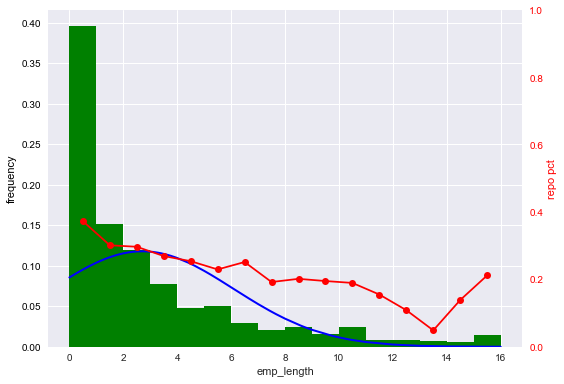

outliers excluded: 152
count    7035.000000
mean        2.708327
std         3.383884
min         0.000000
25%         0.416666
50%         1.000000
75%         4.000000
max        16.000000
Name: emp_length, dtype: float64
skew:  1.8285541776
kurtosis:  2.99381242737


In [29]:
chart_normal(df,'emp_length',o=1,b=16,r=(0,16))

Proof of income

In [35]:
df['poi'].value_counts()

0    3902
1    3285
Name: poi, dtype: int64

Annual Income exploration
- some extreme outliers, 86 entries over 75000 when mean is 26122
- 70% of deals within 15000-35000 range

In [69]:
income_range = [0,10000,15000,20000,25000,30000,35000,40000,75000,1000000]
d = pd.pivot_table(df,values='acv',index='annual_inc',columns='poi',aggfunc='count').reset_index()
d[[0,1]].groupby(pd.cut(d.annual_inc, income_range)).sum()

# .groupby(pd.cut(df.annual_inc, income_range)).count()/df['annual_inc'].count()

poi,0,1
annual_inc,,
"(0, 10000]",69.0,37.0
"(10000, 15000]",241.0,195.0
"(15000, 20000]",662.0,657.0
"(20000, 25000]",894.0,870.0
"(25000, 30000]",613.0,535.0
"(30000, 35000]",457.0,382.0
"(35000, 40000]",302.0,220.0
"(40000, 75000]",472.0,344.0
"(75000, 1000000]",45.0,41.0


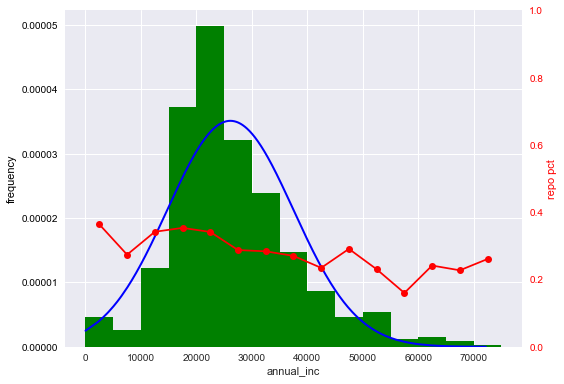

outliers excluded: 101
count     7086.000000
mean     26122.425493
std      11366.704435
min          0.000000
25%      18856.500000
50%      24000.000000
75%      31200.000000
max      72176.000000
Name: annual_inc, dtype: float64
skew:  0.816417889765
kurtosis:  1.37215148358


In [88]:
chart_normal(df,'annual_inc',o=1,r=(0,75000),b=15)

Explore credit scores, including testing for values outside expected ranges
- close to normally distributed, with a significant number of nan entries
- a few values outside expected range, removed in data cleaning

In [ ]:
df[(df.credit_score > 850) | (df.credit_score < 0)]['credit_score'].count()

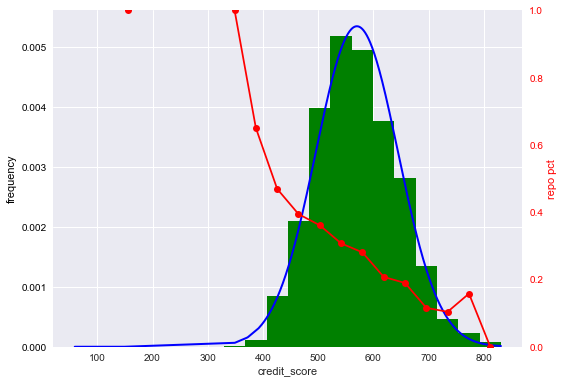

outliers included: 14
count    4323.000000
mean      570.092760
std        74.579884
min        59.000000
25%       518.000000
50%       566.000000
75%       618.000000
max       831.000000
Name: credit_score, dtype: float64
skew:  0.141513626703
kurtosis:  0.539395890534


In [70]:
chart_normal(df,'credit_score',b=20)

Explore cash down, including testing for values outside expected ranges
- entries clustered around known policy guidelines, 500, 750, and 1000,
and to a lesser extent around higher 500 increments

Explore actual cash value of vehicles sold (acv)

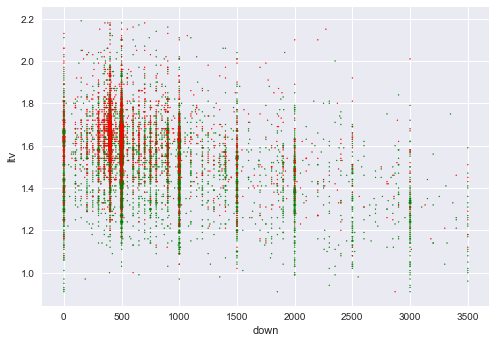

In [85]:
repo_chart(df,'down','ltv',o=1,s_dig=3)

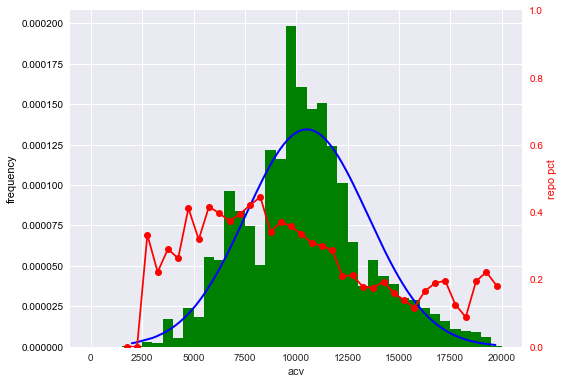

outliers excluded: 32
count     7155.000000
mean     10510.939483
std       2968.136480
min       1995.000000
25%       8695.000000
50%      10495.000000
75%      11995.000000
max      19695.000000
Name: acv, dtype: float64
skew:  0.343517264364
kurtosis:  0.169027349441


In [82]:
chart_normal(df,'acv',b=40,r=(0,20000),o=1)

In [83]:
df[df.down < 0]['down'].count()

0

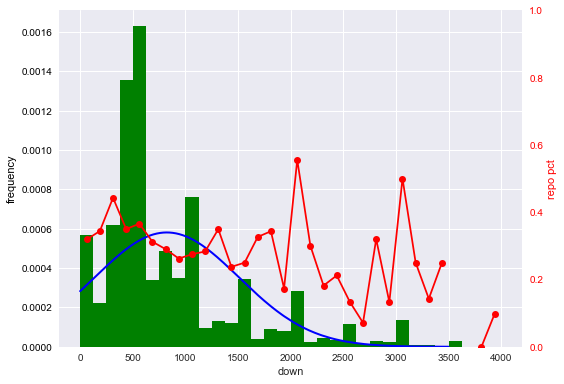

outliers excluded: 109
count    7078.00000
mean      823.52080
std       686.24693
min         0.00000
25%       400.00000
50%       500.00000
75%      1000.00000
max      3500.00000
Name: down, dtype: float64
skew:  1.57701661303
kurtosis:  2.28704435925


In [84]:
chart_normal(df,'down',r=(0,4000),b=32,o=1)

Explore irregular cash payments
- 49.7% of entries are 0
- 30.9% of entries are 500
- All others <3% each

In [ ]:
s = df['def_down'].value_counts()/df['def_down'].count()
s.nlargest(5)

In [ ]:
df[df.def_down < 0]['def_down'].count()

In [ ]:
chart_normal(df,'def_down',r=(0,1750),b=16,o=1)

Gross profit, or sales price over internal cost
- 38 entries with profit below 0, may want to consider excluding or rounding to 0
- clustering around sales targets, 3000
- still significant swings with stdev around 1200

In [ ]:
df['gross_profit'][df.gross_profit < 0].count()

In [ ]:
chart_normal(df,'gross_profit',o=1)

trade_roll exploration
- majority 0 or dollar trades, 69.2% and 12.4% respectively
- consider converting to categorical, or measuring trade deals independently of all deals
- 174 deals over 1000 traderoll

In [ ]:
s = df['trade_roll'].value_counts()/df['trade_roll'].count()
s.nlargest(5)

In [ ]:
chart_normal(df,'trade_roll',r=(1000,6000),b=30,o=1)

VDC Exploration
- only three values, [0,999,2299] represent the majority of values
- 3 excepts on 2229, possible error in data entry

In [ ]:
df['vdc'].value_counts()

In [ ]:
chart_normal(df,'mo_pmt',o=1)

In [ ]:
chart_normal(df,'amt_fin',o=1)